# Test: Verify Dev DB Against Parquet
**Dataset: Flood Exposure**

In [1]:
from typing import Dict

import geopandas as gpd
import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from geojson_pydantic import Feature, Polygon
from shapely import from_geojson
from space2stats import StatsTable, Settings

import os
from os.path import join, expanduser

In [2]:
flood_vars = ['pop', 'pop_flood', 'pop_flood_pct']

__Expected environment variables to be set__ from dotenv file


```.env
PGHOST=
PGPORT=
PGDATABASE=
PGUSER=
PGPASSWORD=
PGTABLENAME=space2stats
```

In [3]:
load_dotenv("./db.env")

True

Connect to the database and print available fields

In [4]:
# with StatsTable.connect() as stats_table:
#     fields = stats_table.fields()

# fields

Define a geometry, in this case we sample a province from SSD


In [5]:
def fetch_admin_boundaries(iso3: str, adm: str) -> gpd.GeoDataFrame:
    """Fetch administrative boundaries from GeoBoundaries API."""
    url = f"https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/"
    res = requests.get(url).json()
    return gpd.read_file(res["gjDownloadURL"])

ISO3 = "SSD"
ADM = "ADM1"
adm_boundaries = fetch_admin_boundaries(ISO3, ADM)
adm_sample = adm_boundaries.sample(1)

In [6]:
row = adm_sample.iloc[0]
row

shapeName                                                Warrap
shapeISO                                                  SS-WR
shapeID                                 48771326B11845073429118
shapeGroup                                                  SSD
shapeType                                                  ADM1
geometry      POLYGON ((29.697964065000065 7.832605446000059...
Name: 9, dtype: object

In [7]:
AOIModel = Feature[Polygon, Dict]

# sample aoi
aoi = {
    "type": "Feature",
    "geometry": row.geometry.__geo_interface__,
    "properties": {"name": row.shapeName},
}


feat = AOIModel(**aoi)

Connect to the database and retrieve hexagons that intersect with the bounding box

In [8]:
with StatsTable.connect() as stats_table:
    data = stats_table.summaries(
        aoi=feat,
        spatial_join_method="touches",
        fields=flood_vars,
        geometry="polygon",
    )
    df = pd.DataFrame(data)

df.head()

,hex_id,geometry,pop,pop_flood,pop_flood_pct
0,866a08007ffffff,"{""type"":""Polygon"",""coordinates"":[[[28.92642772...",130.924270,21.047801,0.160763
1,866a08017ffffff,"{""type"":""Polygon"",""coordinates"":[[[28.87871360...",128.443200,10.125796,0.078835
2,866a0801fffffff,"{""type"":""Polygon"",""coordinates"":[[[28.93474764...",85.793434,6.451794,0.075201
3,866a08027ffffff,"{""type"":""Polygon"",""coordinates"":[[[28.91811179...",142.194340,12.622000,0.088766
4,866a0802fffffff,"{""type"":""Polygon"",""coordinates"":[[[28.97412780...",116.183180,15.139709,0.130309


In [11]:
df["geometry"] = df["geometry"].apply(lambda geom: from_geojson(geom))
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

<Axes: >

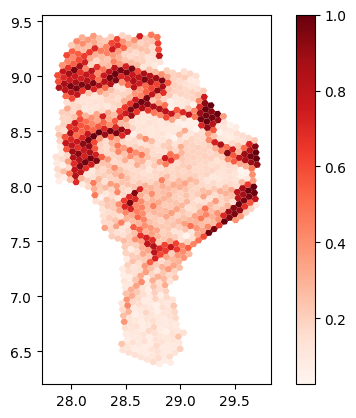

In [12]:
gdf.plot(column="pop_flood_pct", legend=True, cmap="Reds")

Read data from local parquet and merge to existing h3 ids

In [13]:
local_parquet = join(expanduser("~"), "tmp", "s2s", "flood_exposure_15cm_1in100.parquet")
df_local = pd.read_parquet(local_parquet)

In [14]:
gdf_merge = gdf.merge(df_local, on="hex_id", how="left", suffixes=("", "_local"))

In [15]:
flood_vars_local = [f"{var}_local" for var in flood_vars]

In [16]:
gdf_merge.head()

,hex_id,geometry,pop,pop_flood,pop_flood_pct,pop_local,pop_flood_local,pop_flood_pct_local
0,866a08007ffffff,"POLYGON ((28.92643 6.42885, 28.93956 6.45912, ...",130.924270,21.047801,0.160763,130.924271,21.047801,0.160763
1,866a08017ffffff,"POLYGON ((28.87871 6.39405, 28.89185 6.42434, ...",128.443200,10.125796,0.078835,128.443207,10.125796,0.078835
2,866a0801fffffff,"POLYGON ((28.93475 6.37279, 28.94788 6.40308, ...",85.793434,6.451794,0.075201,85.793434,6.451794,0.075201
3,866a08027ffffff,"POLYGON ((28.91811 6.48487, 28.93124 6.51512, ...",142.194340,12.622000,0.088766,142.194336,12.622000,0.088766
4,866a0802fffffff,"POLYGON ((28.97413 6.46363, 28.98725 6.49389, ...",116.183180,15.139709,0.130309,116.183182,15.139709,0.130309


Cast to float32 and check that the data is the same

In [24]:
gdf_merge['pop'] = gdf_merge['pop'].astype('float32')
gdf_merge['pop_flood'] = gdf_merge['pop_flood'].astype('float32')
gdf_merge['pop_flood_pct'] = gdf_merge['pop_flood_pct'].astype('float32')

In [34]:
total_sum = gdf_merge.loc[:, "pop":].sum()
for name, value in total_sum.items():
    print(f"{name}: {value:.5f}")

pop: 1160290.37500
pop_flood: 472344.37500
pop_flood_pct: 382.42426
pop_local: 1160290.37500
pop_flood_local: 472344.38134
pop_flood_pct_local: 382.42424


In [36]:
all(gdf_merge['pop']==gdf_merge['pop_local'])

True

In [37]:
all(gdf_merge['pop_flood']==gdf_merge['pop_flood'])

True

In [38]:
all(gdf_merge['pop_flood_pct']==gdf_merge['pop_flood_pct'])

True